# Partie 1 – Visualisation des données et aide à la définition des seuils conditionnels

## Exctracting datas

In [221]:
# import
import sqlite3
import settings as s
import os
import pandas as pd
import numpy as n
import matplotlib.pyplot as plt
import seaborn as sns

In [222]:
# Extracting all datas
def get_constraints_from_db(db_path):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM ClassificationConstraints LIMIT 1")
    row = cursor.fetchone()
    conn.close()

    if not row:
        raise ValueError("Aucune contrainte trouvée dans la table.")

    columns = [
        "id", "min_size", "max_size", "min_height", "max_height", "min_width", "max_width",
        "min_avg_r", "max_avg_r", "min_avg_g", "max_avg_g", "min_avg_b", "max_avg_b",
        "min_contrast", "max_contrast", "min_edges", "max_edges"
    ]
    return dict(zip(columns, row))

def get_image_from_db(db_path, with_label=False):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    query = "SELECT * FROM Image"

    if (with_label):
        query="SELECT * FROM Image WHERE File_path LIKE 'train/with_label/%' "
    cursor.execute(query)
    rows = cursor.fetchall()
    conn.close()

    rows = n.transpose(rows)

    columns = [
        "id_image", "File_name", "File_path", "Size", "Height", "Width",
        "Date_taken", "Avg_R", "Avg_G", "Avg_B",
        "Contrast_level", "RGB_Histogram", "Luminance_Histogram", "Edges","Status"
    ]
    return dict(zip(columns, rows))

db_path = os.path.join(s.BASE_DIR, "db.sqlite3")

image_data = get_image_from_db(db_path, True)

constraints = get_constraints_from_db(db_path)


In [223]:
image_data = pd.DataFrame(image_data)
image_data.head(5)

,id_image,File_name,File_path,Size,Height,Width,Date_taken,Avg_R,Avg_G,Avg_B,Contrast_level,RGB_Histogram,Luminance_Histogram,Edges,Status
0,661,WhatsApp Image 2020-05-09 at 2.03.38 PM (1).webp,train/with_label/clean/WhatsApp Image 2020-05-...,67.45,748,600,2025-06-23,127.3048462566845,127.7323774509804,135.81869875222816,52.67915025354561,"{""red"": [192.0, 152.0, 142.0, 194.0, 198.0, 17...","[75.0, 179.0, 259.0, 208.0, 243.0, 226.0, 211....",35024,0
1,662,00543_02.webp,train/with_label/clean/00543_02.webp,68.59,600,600,2025-05-28,117.64363055555556,117.13026666666667,116.23090555555557,49.74436375617508,"{""red"": [30.0, 13.0, 14.0, 19.0, 18.0, 39.0, 5...","[2.0, 9.0, 9.0, 10.0, 11.0, 16.0, 24.0, 31.0, ...",48342,0
2,663,WhatsApp Image 2020-05-09 at 2.03.38 PM (3).webp,train/with_label/clean/WhatsApp Image 2020-05-...,51.21,323,600,2025-06-03,129.3281475748194,120.54814241486069,110.3121826625387,63.47775687047143,"{""red"": [24.0, 21.0, 17.0, 29.0, 45.0, 45.0, 5...","[11.0, 80.0, 66.0, 61.0, 87.0, 112.0, 194.0, 1...",42723,0
3,664,WhatsApp Image 2020-05-09 at 2.03.37 PM (6).webp,train/with_label/clean/WhatsApp Image 2020-05-...,23.9,449,600,2025-06-13,129.29189680772086,126.69398292501856,115.66496288047513,42.847949274806794,"{""red"": [0.0, 1.0, 0.0, 2.0, 3.0, 4.0, 9.0, 2....","[0.0, 2.0, 10.0, 13.0, 7.0, 11.0, 7.0, 25.0, 2...",17213,0
4,665,00547_06.webp,train/with_label/clean/00547_06.webp,71.62,600,600,2025-06-04,114.25034722222223,113.7228,109.109825,49.01848935842701,"{""red"": [26.0, 12.0, 9.0, 20.0, 19.0, 43.0, 36...","[2.0, 7.0, 4.0, 5.0, 13.0, 13.0, 23.0, 34.0, 3...",49823,0


In [224]:
constraints

{'id': 1,
 'min_size': 0.0,
 'max_size': 5000.0,
 'min_height': 0,
 'max_height': 5000,
 'min_width': 0,
 'max_width': 5000,
 'min_avg_r': 0.0,
 'max_avg_r': 255.0,
 'min_avg_g': 0.0,
 'max_avg_g': 255.0,
 'min_avg_b': 0.0,
 'max_avg_b': 255.0,
 'min_contrast': 0.0,
 'max_contrast': 1.0,
 'min_edges': 0,
 'max_edges': 10000}

In [225]:
import json
import pandas as pd

# Fonction qui prend la chaîne JSON et renvoie les indices max
def extract_max_indices(hist_str):
    if pd.isna(hist_str):
        return pd.Series([None, None, None], index=["Max_Red_Index", "Max_Green_Index", "Max_Blue_Index"])
    
    hist = json.loads(hist_str)
    r = max(enumerate(hist["red"]), key=lambda x: x[1])[0]
    g = max(enumerate(hist["green"]), key=lambda x: x[1])[0]
    b = max(enumerate(hist["blue"]), key=lambda x: x[1])[0]
    return pd.Series([r, g, b], index=["Max_Red_Index", "Max_Green_Index", "Max_Blue_Index"])

# Application de la fonction sur toute la colonne
image_data[["Max_Red_Index", "Max_Green_Index", "Max_Blue_Index"]] = image_data["RGB_Histogram"].apply(extract_max_indices)


In [226]:
# Convertir les colonnes en float avant la somme pour éviter la concaténation de chaînes
image_data["sum_rgb"] = image_data[["Avg_R", "Avg_G", "Avg_B"]].astype(float).sum(axis=1)
image_data.drop(columns=["id_image", "File_name", "File_path", "Date_taken", "RGB_Histogram", "Luminance_Histogram", "Height", "Width"], inplace=True)

In [227]:
image_data = image_data.astype(float)

In [228]:
image_empty = image_data[image_data["Status"]==0]
image_full = image_data[image_data["Status"]==1]

In [229]:
image_empty

,Size,Avg_R,Avg_G,Avg_B,Contrast_level,Edges,Status,Max_Red_Index,Max_Green_Index,Max_Blue_Index,sum_rgb
0,67.45,127.304846,127.732377,135.818699,52.679150,35024.0,0.0,136.0,121.0,255.0,390.855922
1,68.59,117.643631,117.130267,116.230906,49.744364,48342.0,0.0,108.0,104.0,103.0,351.004803
2,51.21,129.328148,120.548142,110.312183,63.477757,42723.0,0.0,255.0,255.0,111.0,360.188473
3,23.90,129.291897,126.693983,115.664963,42.847949,17213.0,0.0,103.0,99.0,98.0,371.650843
4,71.62,114.250347,113.722800,109.109825,49.018489,49823.0,0.0,103.0,107.0,112.0,337.082972
5,82.88,116.279930,114.280882,114.431877,64.878854,62421.0,0.0,255.0,255.0,255.0,344.992689
6,69.07,122.386572,127.302589,121.965289,56.431535,43440.0,0.0,116.0,120.0,119.0,371.654450
7,28.85,111.080030,111.900614,105.170648,53.863528,10868.0,0.0,255.0,255.0,255.0,328.151292
8,57.77,122.540070,121.577120,120.122662,39.285750,23490.0,0.0,144.0,145.0,159.0,364.239852
9,48.39,130.774884,119.738655,111.431787,65.330094,33959.0,0.0,255.0,255.0,255.0,361.945326


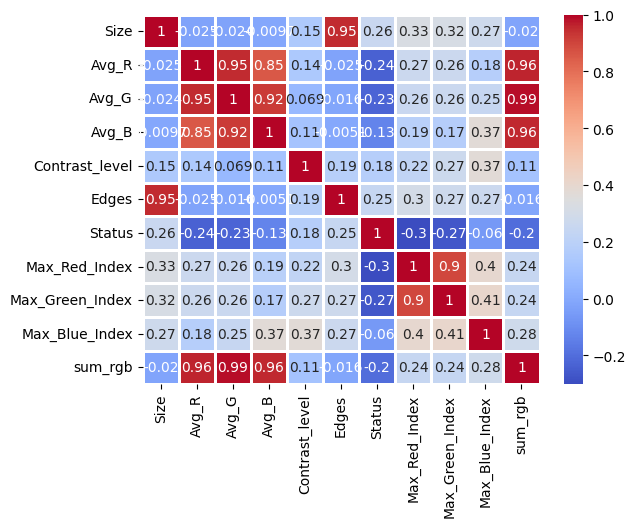

In [230]:
corr = image_data.corr ()
sns.heatmap(corr, cmap='coolwarm', annot = True, linewidth =0.9)
plt.show()

**Analyse :** On va utiliser les variables avec une correlation superieure à 0.2 

## Rules Tuning

In [231]:
def fit_polynomial(df, x_col, y_col, degree=2):
    """
    Ajuste une régression polynomiale sur tout le DataFrame et renvoie une fonction polynomiale utilisable.
    
    Args:
        df (pd.DataFrame): Tableau avec les données.
        x_col (str): Nom de la colonne x.
        y_col (str): Nom de la colonne y.
        degree (int): Degré du polynôme.
        
    Returns:
        np.poly1d: La fonction polynomiale.
    """
    coefs = n.polyfit(df[x_col], df[y_col], deg=degree)
    poly_fn = n.poly1d(coefs)
    return poly_fn

image_empty["x"] = n.arange(len(image_empty["Edges"]))
image_full["x"] = n.arange(len(image_full["Edges"]))



/var/folders/s8/0f2wgqdd6953wlwbgn3cr_480000gn/T/ipykernel_6904/1616423379.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  image_empty["x"] = n.arange(len(image_empty["Edges"]))
/var/folders/s8/0f2wgqdd6953wlwbgn3cr_480000gn/T/ipykernel_6904/1616423379.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  image_full["x"] = n.arange(len(image_full["Edges"]))


### Edges

In [232]:
s = {
    'count': image_empty["Edges"].count(),
    'min': image_empty["Edges"].min(),
    'max': image_empty["Edges"].max(),
    'median': image_empty["Edges"].median(),
    'mean': image_empty["Edges"].mean(),
    'std': image_empty["Edges"].std()
}

print("Edges - Empty")
for key, value in s.items():
    print(f"{key.capitalize():<8}: {value}")

s = {
    'count': image_full["Edges"].count(),
    'min': image_full["Edges"].min(),
    'max': image_full["Edges"].max(),
    'median': image_full["Edges"].median(),
    'mean': image_full["Edges"].mean(),
    'std': image_full["Edges"].std()
}

print("\nEdges - Full")
for key, value in s.items():
    print(f"{key.capitalize():<8}: {value}")


Edges - Empty
Count   : 20
Min     : 10868.0
Max     : 123955.0
Median  : 40885.0
Mean    : 42711.05
Std     : 24430.171060596364

Edges - Full
Count   : 20
Min     : 5876.0
Max     : 2012176.0
Median  : 41290.5
Mean    : 200637.45
Std     : 450695.9001746749


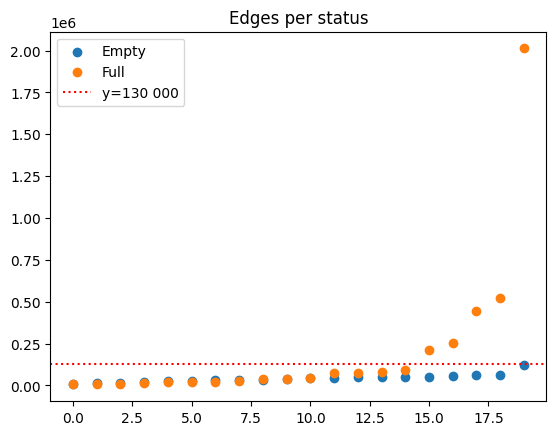

In [233]:
plt.scatter(image_empty["x"], sorted(image_empty["Edges"]), label="Empty")
plt.scatter(image_full["x"], sorted(image_full["Edges"]), label="Full")
plt.axhline(y=130000, color='red', linestyle=':', label='y=130 000')
plt.title("Edges per status")
plt.legend()
plt.show()

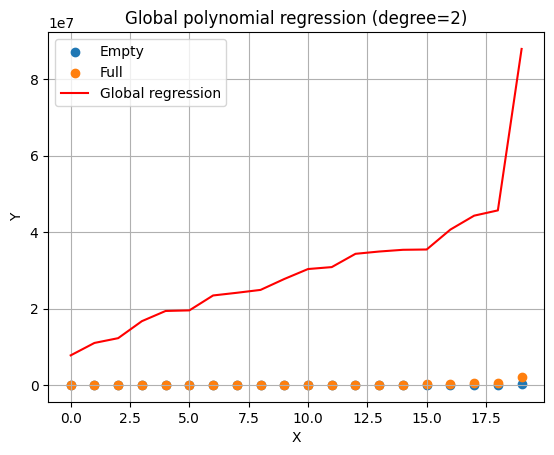

In [234]:
image_empty_sorted = image_empty.sort_values(by="Edges")

poly_fn = fit_polynomial(image_empty_sorted, "x", "Edges", 1)

plt.scatter(image_empty["x"], sorted(image_empty["Edges"]), label="Empty")
plt.scatter(image_full["x"], sorted(image_full["Edges"]), label="Full")
plt.plot(image_empty["x"], poly_fn(image_empty_sorted["Edges"]), color="red", label="Global regression")

plt.xlabel("X")
plt.ylabel("Y")
plt.title("Global polynomial regression (degree=2)")
plt.legend()
plt.grid(True)
plt.show()

L'utilisation de la regréssion polynomiale ne sera malheureusement pas utilisée sous la contrainte du cahier des charges.

### Size

In [235]:
s = {
    'count': image_full["Size"].count(),
    'min': image_full["Size"].min(),
    'max': image_full["Size"].max(),
    'median': image_full["Size"].median(),
    'mean': image_full["Size"].mean(),
    'std': image_full["Size"].std()
}
print("Size - Full")
for key, value in s.items():
    print(f"{key.capitalize():<8}: {value}")

s = {
    'count': image_empty["Size"].count(),
    'min': image_empty["Size"].min(),
    'max': image_empty["Size"].max(),
    'median': image_empty["Size"].median(),
    'mean': image_empty["Size"].mean(),
    'std': image_empty["Size"].std()
}
print("Size - Empty")
for key, value in s.items():
    print(f"{key.capitalize():<8}: {value}")


Size - Full
Count   : 20
Min     : 20.95
Max     : 6458.14
Median  : 68.98
Mean    : 730.794
Std     : 1524.2758680812135
Size - Empty
Count   : 20
Min     : 23.9
Max     : 1821.85
Median  : 63.870000000000005
Mean    : 152.734
Std     : 394.35618312970774


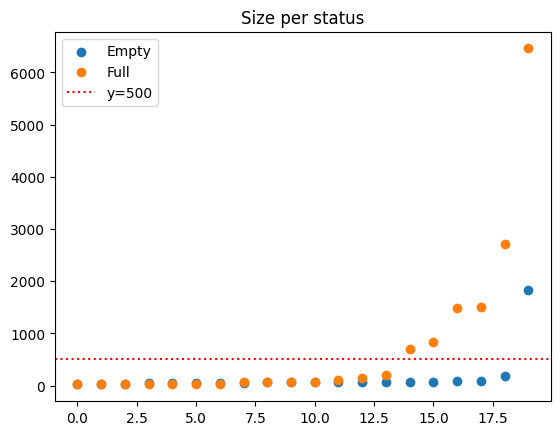

In [236]:
# Conversion des colonnes "Edges" en float pour le tri et le tracé
size_empty = image_empty["Size"].astype(float)
size_full = image_full["Size"].astype(float)

plt.scatter(n.arange(len(size_empty)), sorted(size_empty), label="Empty")
plt.scatter(n.arange(len(size_full)), sorted(size_full), label="Full")
plt.axhline(y=500, color='red', linestyle=':', label='y=500')
plt.title("Size per status")
plt.legend()
plt.show()

### Avg_R / Avg_G

In [237]:
s = {
    'count': image_full["Avg_R"].count(),
    'min': image_full["Avg_R"].min(),
    'max': image_full["Avg_R"].max(),
    'median': image_full["Avg_R"].median(),
    'mean': image_full["Avg_R"].mean(),
    'std': image_full["Avg_R"].std()
}
print("Avg_R - Full")
for key, value in s.items():
    print(f"{key.capitalize():<8}: {value}")

s = {
    'count': image_empty["Avg_R"].count(),
    'min': image_empty["Avg_R"].min(),
    'max': image_empty["Avg_R"].max(),
    'median': image_empty["Avg_R"].median(),
    'mean': image_empty["Avg_R"].mean(),
    'std': image_empty["Avg_R"].std()
}
print("Avg_R - Empty")
for key, value in s.items():
    print(f"{key.capitalize():<8}: {value}")


Avg_R - Full
Count   : 20
Min     : 66.51735013232229
Max     : 139.30618055555556
Median  : 118.44797049645024
Mean    : 114.71940910147654
Std     : 16.15475000020613
Avg_R - Empty
Count   : 20
Min     : 106.65031821045999
Max     : 135.22823675
Median  : 121.20721339407494
Mean    : 120.78120283876369
Std     : 8.001536085382368


In [238]:
s = {
    'count': image_full["Avg_G"].count(),
    'min': image_full["Avg_G"].min(),
    'max': image_full["Avg_G"].max(),
    'median': image_full["Avg_G"].median(),
    'mean': image_full["Avg_G"].mean(),
    'std': image_full["Avg_G"].std()
}
print("Avg_G - Full")
for key, value in s.items():
    print(f"{key.capitalize():<8}: {value}")

s = {
    'count': image_empty["Avg_G"].count(),
    'min': image_empty["Avg_G"].min(),
    'max': image_empty["Avg_G"].max(),
    'median': image_empty["Avg_G"].median(),
    'mean': image_empty["Avg_G"].mean(),
    'std': image_empty["Avg_G"].std()
}
print("Avg_G - Empty")
for key, value in s.items():
    print(f"{key.capitalize():<8}: {value}")


Avg_G - Full
Count   : 20
Min     : 70.49837595552195
Max     : 143.449075
Median  : 117.01438215748877
Mean    : 114.59459506101743
Std     : 15.59657766125651
Avg_G - Empty
Count   : 20
Min     : 109.90411043051611
Max     : 132.25371111111113
Median  : 119.73313861661244
Mean    : 120.01099547882468
Std     : 6.184148797626644


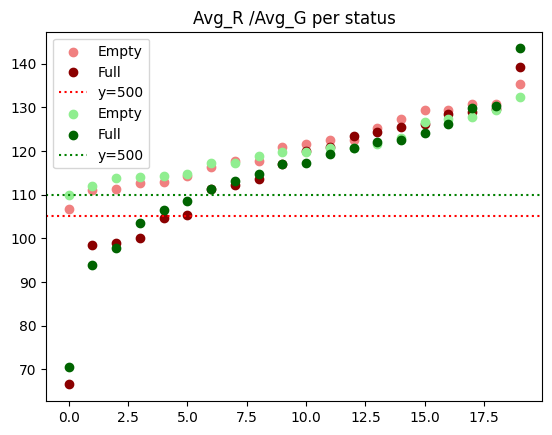

In [239]:
avg_r_empty = image_empty["Avg_R"].astype(float)
avg_r_full = image_full["Avg_R"].astype(float)
avg_g_empty = image_empty["Avg_G"].astype(float)
avg_g_full = image_full["Avg_G"].astype(float)
plt.scatter(n.arange(len(avg_r_empty)), sorted(avg_r_empty), label="Empty", color='lightcoral')
plt.scatter(n.arange(len(avg_r_full)), sorted(avg_r_full), label="Full", color='darkred')
plt.axhline(y=105, color='red', linestyle=':', label='y=500')
plt.scatter(n.arange(len(avg_g_empty)), sorted(avg_g_empty), label="Empty", color='lightgreen')
plt.scatter(n.arange(len(avg_g_full)), sorted(avg_g_full), label="Full", color='darkgreen')
plt.axhline(y=110, color='green', linestyle=':', label='y=500')
plt.title("Avg_R /Avg_G per status")
plt.legend()
plt.show()

### Max_Red_index/Max_green_index

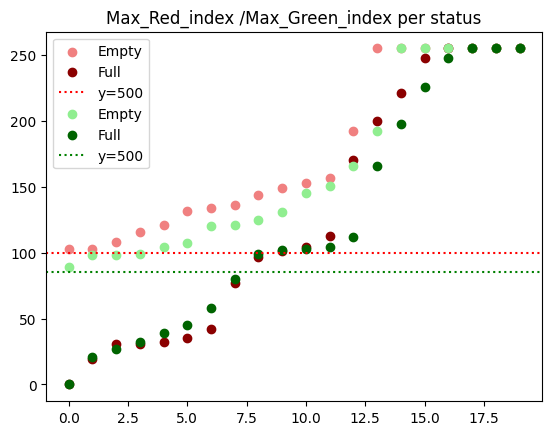

In [240]:
max_red_empty = image_empty["Max_Red_Index"].astype(float)
max_red_full = image_full["Max_Red_Index"].astype(float)
max_green_empty = image_empty["Max_Green_Index"].astype(float)
max_green_full = image_full["Max_Green_Index"].astype(float)
plt.scatter(n.arange(len(max_red_empty)), sorted(max_red_empty), label="Empty", color='lightcoral')
plt.scatter(n.arange(len(max_red_full)), sorted(max_red_full), label="Full", color='darkred')
plt.axhline(y=100, color='red', linestyle=':', label='y=500')
plt.scatter(n.arange(len(max_green_empty)), sorted(max_green_empty), label="Empty", color='lightgreen')
plt.scatter(n.arange(len(max_green_full)), sorted(max_green_full), label="Full", color='darkgreen')
plt.axhline(y=85, color='green', linestyle=':', label='y=500')
plt.title("Max_Red_index /Max_Green_index per status")
plt.legend()
plt.show()

### Sum_rgb

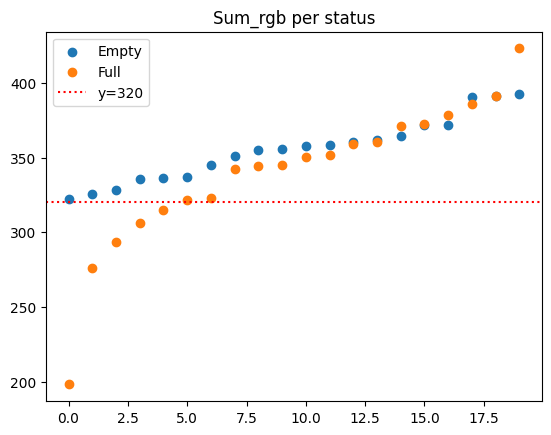

In [241]:
# Conversion des colonnes "Edges" en float pour le tri et le tracé
sum_rgb_empty = image_empty["sum_rgb"].astype(float)
sum_rgb_full = image_full["sum_rgb"].astype(float)

plt.scatter(n.arange(len(sum_rgb_empty)), sorted(sum_rgb_empty), label="Empty")
plt.scatter(n.arange(len(sum_rgb_full)), sorted(sum_rgb_full), label="Full")
plt.axhline(y=320, color='red', linestyle=':', label='y=320')
plt.title("Sum_rgb per status")
plt.legend()
plt.show()

# Conditional Model

In [242]:

# Exemple de structure de règle : 

rules = [{"feature": "Size", "operator": ">", "threshold": 500, "score": 0.26},
         {"feature": "Avg_R", "operator": "<", "threshold": 105, "score": 0.24/2},
         {"feature": "Avg_G", "operator": "<", "threshold": 110, "score": 0.23/2},
         {"feature": "Edges", "operator": ">", "threshold": 130000, "score": 0.25},
         {"feature": "Max_Red_Index", "operator": "<", "threshold": 100, "score": 0.3/2}, # diviser par deux car redondant.
         {"feature": "Max_Green_Index", "operator": "<", "threshold": 85, "score": 0.27/2},
         {"feature": "sum_rgb", "operator": "<", "threshold": 320, "score": 0.2}
         ]

def apply_rule(row, rule):
    if rule["operator"] == ">":
        return row[rule["feature"]] > rule["threshold"]
    elif rule["operator"] == "<":
        return row[rule["feature"]] < rule["threshold"]
    elif rule["operator"] == ">=":
        return row[rule["feature"]] >= rule["threshold"]
    elif rule["operator"] == "<=":
        return row[rule["feature"]] <= rule["threshold"]
    elif rule["operator"] == "==":
        return row[rule["feature"]] == rule["threshold"]
    else:
        return False

def predict_status(data, rules, threshold_score=1):
    # Pour Max_Red_index et Max_Green_index
    def extract_max_indices(hist_str):
        if pd.isna(hist_str):
            return pd.Series([None, None, None], index=["Max_Red_Index", "Max_Green_Index", "Max_Blue_Index"])
        
        hist = json.loads(hist_str)
        r = max(enumerate(hist["red"]), key=lambda x: x[1])[0]
        g = max(enumerate(hist["green"]), key=lambda x: x[1])[0]
        b = max(enumerate(hist["blue"]), key=lambda x: x[1])[0]
        return pd.Series([r, g, b], index=["Max_Red_Index", "Max_Green_Index", "Max_Blue_Index"])

    """ data[["Max_Red_Index", "Max_Green_Index", "Max_Blue_Index"]] = data["RGB_Histogram"].apply(extract_max_indices)
    data["sum_rgb"] = data[["Avg_R", "Avg_G", "Avg_B"]].astype(float).sum(axis=1)
 """
    # return True == status full
    predictions = []
    for _, row in data.iterrows():
        score = 0
        for rule in rules:
            if apply_rule(row, rule):
                score += rule["score"]
        predicted_status = 1 if score >= threshold_score else 0
        predictions.append(predicted_status)
    return predictions


# Model test - classification metrics

In [ ]:
# Exctracting test datas
def get_image_from_db(db_path, with_label=False):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    query = "SELECT * FROM Image"

    if (with_label):
        query="SELECT * FROM Image WHERE File_path LIKE 'train/with_label/%' "
    cursor.execute(query)
    rows = cursor.fetchall()
    conn.close()

    rows = n.transpose(rows)

    columns = [
        "id_image", "File_name", "File_path", "Size", "Height", "Width",
        "Date_taken", "Avg_R", "Avg_G", "Avg_B",
        "Contrast_level", "RGB_Histogram", "Luminance_Histogram", "Edges","Status"
    ]
    return dict(zip(columns, rows))

db_path = os.path.join(s.BASE_DIR, "db.sqlite3")

image_data = get_image_from_db(db_path, True)

In [247]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report


image_data["Predicted_Status"] = predict_status(image_data, rules, threshold_score=0.2)

y_true = image_data["Status"]
y_pred = image_data["Predicted_Status"]

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("Recall:", recall_score(y_true, y_pred))
print("F1 Score:", f1_score(y_true, y_pred))
print("Matrice de confusion:", confusion_matrix(y_true, y_pred))
print("Rapport de classification:", classification_report(y_true, y_pred))


Accuracy: 0.85
Precision: 0.9375
Recall: 0.75
F1 Score: 0.8333333333333334
Matrice de confusion: [[19  1]
 [ 5 15]]
Rapport de classification:               precision    recall  f1-score   support

         0.0       0.79      0.95      0.86        20
         1.0       0.94      0.75      0.83        20

    accuracy                           0.85        40
   macro avg       0.86      0.85      0.85        40
weighted avg       0.86      0.85      0.85        40

